# CNN model for classification of audio files with genre tags

In [ ]:
#importing the spectrogram images stored in a zip file
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/colab_data/music_caps.zip","r") as zip_ref:
    zip_ref.extractall("/content/melspecs")

In [1]:
#importing necessary libraries
import numpy as np
import pandas as pd
import cv2
pd.options.mode.chained_assignment = None  # default='warn'
import os
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras.models import load_model

2024-03-12 17:26:39.640636: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-12 17:26:39.681778: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 17:26:40.360020: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#checking the no. of spectrograms and their size
mel_dir = '/home/mendu/Thesis/data/musiccaps/audio'
mel_list = os.listdir(mel_dir)
# mel_npy = np.load(f'{mel_dir}/{mel_list[25]}') #loading the 26th file to check the size
print('Count of npy files: ', len(mel_list))
# print('Size of image: ', mel_npy.shape)

Count of npy files:  5431


In [3]:
import json

# Specify the path to your JSON file
json_file_path = '/home/mendu/Thesis/data/musiccaps/dataset_train.json'

# Open and read the JSON file
with open(json_file_path, 'r') as json_file:
    data = json.load(json_file)

df = pd.DataFrame(data)

# Display the DataFrame
print(df)

      audio_id                                            caption  \
0         3191  This opera song features a female voice singin...   
1          179  A group of male vocalists sing this happy, upb...   
2         4695  This is an amateur recording of a Bavarian fol...   
3          921  This song features a choir with male and femal...   
4          544  An acoustic drum is playing a rock groove with...   
...        ...                                                ...   
4411      3838  This song is a romantic duet.the tempo is medi...   
4412      2827  This song features the sound of two church bel...   
4413      4385  A full orchestra is playing a descending melod...   
4414      1172  This is a live performance of what sounds like...   
4415      5453  This is a movie music piece. There is a female...   

                                             audio_path  
0     /home/dil60393/music_caps_dataset/[XWj7nP7kfdQ...  
1     /home/dil60393/music_caps_dataset/[0XxinBtKouQ...

In [4]:
df

,audio_id,caption,audio_path
0,3191,This opera song features a female voice singin...,/home/dil60393/music_caps_dataset/[XWj7nP7kfdQ...
1,179,"A group of male vocalists sing this happy, upb...",/home/dil60393/music_caps_dataset/[0XxinBtKouQ...
2,4695,This is an amateur recording of a Bavarian fol...,/home/dil60393/music_caps_dataset/[pHFHsubQVpg...
3,921,This song features a choir with male and femal...,/home/dil60393/music_caps_dataset/[8PcfPX11Hjg...
4,544,An acoustic drum is playing a rock groove with...,/home/dil60393/music_caps_dataset/[4BIIFU_b6BY...
...,...,...,...
4411,3838,This song is a romantic duet.the tempo is medi...,/home/dil60393/music_caps_dataset/[e2tZmQI8ICw...
4412,2827,This song features the sound of two church bel...,/home/dil60393/music_caps_dataset/[TIASpLtI8ks...
4413,4385,A full orchestra is playing a descending melod...,/home/dil60393/music_caps_dataset/[lDsQWSf1h3I...
4414,1172,This is a live performance of what sounds like...,/home/dil60393/music_caps_dataset/[AobHGHJSd-s...


## Descriptive analysis of the MusicCaps audio files, metadata and tags

In [6]:
#Extracting the audio file names
# Remove '.wav.mp3' from each element in the list
audio_list = [file_name.replace('.wav.mp3', '') for file_name in mel_list]

print(audio_list)

['[eWGGj4duzIo]-[110-120]', '[YBbvQ0RPrG8]-[100-110]', '[9Y8NR6nDxjk]-[460-470]', '[1Ccis4FDGwY]-[20-30]', '[OM04OFjNPGw]-[150-160]', '[L5UDz2PJ9sk]-[30-40]', '[-taO6N-rxv4]-[30-40]', '[YTZK9FNgK74]-[30-40]', '[idVCpQaByc4]-[70-80]', '[MPxwPOOIskc]-[250-260]', '[aPQTrv2B1sw]-[250-260]', '[s2O2xaRfje0]-[360-370]', '[5bn7PPKcqSA]-[0-10]', '[kuj0Oi2_7yU]-[0-10]', '[rmKh9uaikTU]-[30-40]', '[aHZdDmYFZN0]-[380-390]', '[xeHt-R5ScmI]-[0-10]', '[QZoclbefgak]-[30-40]', '[9QEm6u4bowQ]-[30-40]', '[gp1DYuoQH08]-[40-50]', '[HHZGjS4g-w4]-[30-40]', '[0a91szM1Ivw]-[30-40]', '[bHNdoIWxXDk]-[200-210]', '[ZVvX2-ldhvY]-[30-40]', '[nvoGwmKh6NI]-[30-40]', '[P-eIhvCaK-s]-[90-100]', '[PaQGXIh94uc]-[150-160]', '[poxsF3-HeP0]-[30-40]', '[9-R70gSqvrc]-[30-40]', '[K55v5p5DEPE]-[0-10]', '[OiAJB9uydS8]-[100-110]', '[1W2FOzSXsxs]-[30-40]', '[Ofry7lyQZDA]-[90-100]', '[VzFpg271sm8]-[500-510]', '[qni67aUJbw4]-[160-170]', '[9jeEfi6nDak]-[30-40]', '[Akg1n9IWSrw]-[0-10]', '[b-Cr0EWwaTk]-[140-150]', '[doX8FjlNPf8]-[30-40]',

In [13]:
#Import paraquet files from "https://huggingface.co/datasets/seungheondoh/LP-MusicCaps-MC/tree/main/data"
test_tags = pd.read_parquet('/home/mendu/Thesis/data/musiccaps/test-00000-of-00001-7f4171b43c96395e.parquet', engine='pyarrow')
train_tags = pd.read_parquet('/home/mendu/Thesis/data/musiccaps/train-00000-of-00001-c4a67f61bdb1fbf4.parquet', engine='pyarrow')

In [29]:
#Printing the head of the train tags dataframe
train_tags.head()

,fname,ytid,aspect_list,caption_ground_truth,caption_writing,caption_summary,caption_paraphrase,caption_attribute_prediction,pseudo_attribute,is_crawled,author_id,start_s,end_s,audioset_positive_labels,is_balanced_subset,is_audioset_eval
0,[-0SdAVK79lg]-[30-40],-0SdAVK79lg,"[guitar song, piano backing, simple percussion...",This song features an electric guitar as the m...,This gentle guitar song featuring a piano back...,This instrumental song features a relaxing mel...,The instrumental guitar song boasts a soothing...,This instrumental guitar song has a soft and r...,"[acoustic, folksy, chord progression]",True,0,30,40,"/m/0155w,/m/01lyv,/m/0342h,/m/042v_gx,/m/04rlf...",False,False
1,[-1LrH01Ei1w]-[30-40],-1LrH01Ei1w,"[rubab instrument, repetitive melody on differ...",This song features a rubber instrument being p...,An energizing instrumental track featuring the...,A fast tempo instrumental song featuring the r...,Experience the electrifying prowess of the tru...,This instrumental song features the rubab inst...,"[drum, bass guitar]",True,0,30,40,"/m/02p0sh1,/m/04rlf",False,False
2,[-4NLarMj4xU]-[30-40],-4NLarMj4xU,"[pop, tinny wide hi hats, mellow piano melody,...",The Pop song features a soft female vocal sing...,This pop ballad is filled with a mix of tinny ...,"The pop song features a mellow piano melody, s...",This pop ballad features a delicate piano melo...,This pop ballad features tinny wide hi hats an...,"[solo guitar, subtle strings, bright acoustic ...",True,4,30,40,"/m/04rlf,/t/dd00034",False,False
3,[-5f6hjZf9Yw]-[30-40],-5f6hjZf9Yw,"[folk music, rubab, male voice, slow tempo, em...",This folk song features a male voice singing t...,This emotional folk ballad features a poignant...,"A slow, emotional folk song featuring a male v...",This touching folk ballad featuring a male voc...,This heart-wrenching folk song features a mesm...,"[harmonica, melancholic lyrics, acoustic guitar]",True,0,30,40,"/m/02w4v,/m/04rlf",False,False
4,[-5xOcMJpTUk]-[70-80],-5xOcMJpTUk,"[guitarist, male talking, twang sounds, medioc...",A male guitarist plays the guitar and speaks a...,This energetic song demo features a passionate...,This energetic and passionate song features a ...,This home music video showcases a male guitari...,This home music video features a male guitaris...,"[electric guitar, rock genre, guitar riff, gui...",True,1,70,80,"/m/018vs,/m/0342h,/m/042v_gx,/m/04rlf,/m/04szw...",False,False


In [28]:
#Printing the columns in the tags files
train_tags.columns

Index(['fname', 'ytid', 'aspect_list', 'caption_ground_truth',
       'caption_writing', 'caption_summary', 'caption_paraphrase',
       'caption_attribute_prediction', 'pseudo_attribute', 'is_crawled',
       'author_id', 'start_s', 'end_s', 'audioset_positive_labels',
       'is_balanced_subset', 'is_audioset_eval'],
      dtype='object')

In [23]:
test_tag_name = test_tags['fname'].tolist()
train_tag_name = train_tags['fname'].tolist()
combined_tags = test_tag_name + train_tag_name

In [22]:
print('The length of the train tags are', len(train_tag_name))
print('The length of the test tags are', len(test_tag_name))

The length of the train tags are 2663
The length of the test tags are 2858


In [30]:
if set(audio_list).issubset(set(combined_tags)):
    print('The audio files all have a tag row from the paraquet files')

The audio files all have a tag row from the paraquet files


In [39]:
#the aspect_list col as a list
tags_list = train_tags['aspect_list'].to_list() + test_tags['aspect_list'].to_list()

# Flatten the tags_list
flat_list = [item for sublist in tags_list for item in sublist]

# Remove duplicates
tags_list = list(set(flat_list))

print(tags_list)

['liquid', 'deafening', 'crowd talking', 'syncopate snare hits', 'vintage super hits', 'filtered monotone male vocal', 'timeless', 'church choir', 'playing alone', 'bass drum pedal', 'downward bend', 'instrumental musical song fading', 'tense atmosphere', 'casual', 'international', 'motivational song', 'ballad/pop', 'electronic drone sound', 'indian mythology', 'rapid riff', 'uzbek folk music', 'popular folk music', 'high-pitched singing', 'ethereal tones', 'confident rapper', 'synthesizer arpeggios', 'choral melody', 'very bad audio quality', 'tabla playing steadily', 'sharp electronic clap', 'lounge techno music', 'clap', 'upbeat electronic riff', 'ambient  emphatic', 'mice sounds effects', 'addictive staccato violin melody', 'rhythmic spanish guitar', 'auxiliary percussion instruments', 'male grunts sound effect', 'string duet', 'dobro', 'rock/ska', 'relatable', 'low pitched strings', 'deteriorated music quality', 'straight bass lines', 'tension', 'good friday', 'african music', 'so

In [40]:
len(tags_list)

13219

## Loading the mtg dataframe and filtering it to include top 5 genres from the sample

In [ ]:
#importing csv that contains the metafile of all the tracks
df_all = pd.read_csv('/content/mtg_cleaned.csv', index_col = [0])

In [ ]:
df_all.head()

,track_id,artist_id,album_id,path,duration,genre,instrument,mood
1,214,14,31,14/214.mp3,124.6,punkrock,NaN,NaN
2,215,14,31,15/215.mp3,151.4,metal,NaN,NaN
3,216,14,31,16/216.mp3,234.9,metal,NaN,NaN
4,217,14,31,17/217.mp3,127.9,punkrock,NaN,NaN
5,218,14,31,18/218.mp3,180.7,punkrock,NaN,NaN


In [ ]:
#list of all the track_ids in the sample zip file
track_ids = [int(file_name.replace('_30-60.npy', '')) for file_name in mel_list]

#filtering only those tracks to the dataset
df = df_all[df_all['track_id'].isin(track_ids)]

#only taking the first genre from the genre column
df['genre'] = df['genre'].str.split(',').str[0]

#only keeping the tracks and genre column
df = df[['track_id', 'genre']]

In [ ]:
#calculating the most frequent genres in the sample and only keeping the top five in the df
genre_count = pd.DataFrame(df.genre.value_counts().rename_axis('genre').reset_index(name='counts'))

#list of top five genres
top_genres = list(genre_count.genre[:10])

#filtering df to only keep
df = df[df['genre'].isin(top_genres)].sort_values(by = 'track_id', ascending = True).reset_index(drop = True)

df

,track_id,genre
0,3524,electronic
1,4629,ambient
2,6606,dance
3,6607,dance
4,6608,dance
...,...,...
3936,1420700,chillout
3937,1420704,dance
3938,1420705,dance
3939,1420706,dance


In [ ]:
#List of all the track_ids that are in the sample and have top5
train_track_ids = list(df['track_id'].values)

In [ ]:
#check these elements against the output of the "loading the cropped .npy files" cell
train_track_ids[:5]

[3524, 4629, 6606, 6607, 6608]

# Training the model

In [ ]:
def add_gauss_noise(image, mean = 0, var = 10):
    '''function to add gaussian noise to an image'''
    sigma = var ** 0.5

    #creating a noise image with gaussian distribution
    gaussian = np.random.normal(mean, sigma, (img.shape[0], img.shape[1]))

    #creating a zeroes image
    noisy_image = np.zeros(img.shape, np.float32)

    #adding the noise to the original image
    noisy_image = img + gaussian

    #normalising the image
    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)

    #changing type
    noisy_image = noisy_image.astype(np.uint8)

    return noisy_image

In [ ]:
#loading the cropped .npy files

folder_path_mel = '/content/sample_mel'
filenames = os.listdir(folder_path_mel)

data = []
i = 0

for filename in train_track_ids:
  filename_npy = str(filename) + '_30-60.npy'
  file_path = os.path.join(folder_path_mel, filename_npy)
  img = np.load(file_path)
  data.append(add_gauss_noise(img))
  if i < 10 :
    print(filename)
  i = i+1

data = np.array(data)


3524
4629
6606
6607
6608
6609
6610
6611
6719
6720


In [ ]:
#normalize data
data = data.astype('float32')/255.0

In [ ]:
data.shape

(3941, 96, 1406)

In [ ]:
# Reshape data to include the channel dimension
data = data.reshape((-1, 96, 1406, 1))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, pd.get_dummies(df['genre']), test_size=0.1, random_state=42)

In [ ]:
# Initialize ImageDataGenerator with necessary augmentations
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2
)

datagen.fit(X_train)

In [ ]:
'''creates a custom data generator for data augmentation and adds gaussian noise to 20% of the training data and mixup to all'''

# # Define a Mixup function
# def mixup(X, y, alpha=0.2):
#     if np.random.rand() < 0.2:  # Apply Mixup to 20% of the images
#         batch_size = X.shape[0]
#         l = np.random.beta(alpha, alpha, batch_size)
#         X_l = l.reshape(batch_size, 1, 1, 1)
#         y_l = l.reshape(batch_size, 1)

#         X_mixup = X * X_l + X[::-1] * (1 - X_l)
#         y_mixup = y * y_l + y[::-1] * (1 - y_l)
#         return X_mixup, y_mixup
#     else:
#         return X, y

# # Create an augmenter for Gaussian noise
# gaussian_noise = iaa.AdditiveGaussianNoise(scale=0.01 * 255)

# # Define the custom generator
# def custom_generator(datagen, gaussian_noise, X_train, Y_train, batch_size):
#     generator = datagen.flow(X_train, Y_train, batch_size=batch_size)
#     while True:
#         X_batch, y_batch = next(generator)

#         # Decide whether to apply Gaussian noise
#         if np.random.rand() < 0.2:  # Apply Gaussian noise to 20% of the images
#             X_batch = gaussian_noise.augment_images(X_batch)

#         # Apply Mixup
#         X_batch, y_batch = mixup(X_batch, y_batch)
#         yield X_batch, y_batch

# # Usage example
# batch_size = 32
# alpha = 0.2  # Adjust Mixup's alpha value if needed
# augmented_data_gen = custom_generator(datagen, gaussian_noise, X_train, y_train, batch_size)

In [ ]:
# Define num_classes based on the number of unique genres
num_classes = y_train.shape[1]
num_classes

In [ ]:
#l2 regularisation
ltwo_reg = 0.0

# Initialize the model
model = Sequential()

#Convolution layers
model.add(Conv2D(32, (3, 3), kernel_regularizer=l2(ltwo_reg), input_shape=(96, 1406, 1), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layers with L2 regularization
model.add(Dense(128, kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(ltwo_reg)))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 1404, 32)      288       
                                                                 
 batch_normalization (Batch  (None, 94, 1404, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 94, 1404, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 702, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 700, 64)       18432     
                                                                 
 batch_normalization_1 (Bat  (None, 45, 700, 64)       2

In [ ]:
# Train model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

# history = model.fit(
#     augmented_data_gen,
#     steps_per_epoch=len(X_train) // batch_size,
#     epochs=10,  # Number of epochs to train for
#     validation_data=(X_val, y_val)
# )

Epoch 1/10
111/111 [==============================] - 13s 62ms/step - loss: 2.2613 - accuracy: 0.2685 - val_loss: 2.1117 - val_accuracy: 0.2329
Epoch 2/10
111/111 [==============================] - 4s 40ms/step - loss: 1.8785 - accuracy: 0.3613 - val_loss: 2.2699 - val_accuracy: 0.1797
Epoch 3/10
111/111 [==============================] - 4s 40ms/step - loss: 1.5412 - accuracy: 0.4749 - val_loss: 2.5910 - val_accuracy: 0.2962
Epoch 4/10
111/111 [==============================] - 4s 39ms/step - loss: 1.1248 - accuracy: 0.6331 - val_loss: 3.1000 - val_accuracy: 0.2380
Epoch 5/10
111/111 [==============================] - 4s 39ms/step - loss: 0.6864 - accuracy: 0.8003 - val_loss: 3.3956 - val_accuracy: 0.2506
Epoch 6/10
111/111 [==============================] - 4s 39ms/step - loss: 0.3883 - accuracy: 0.9106 - val_loss: 3.6677 - val_accuracy: 0.2354
Epoch 7/10
111/111 [==============================] - 4s 39ms/step - loss: 0.2090 - accuracy: 0.9645 - val_loss: 3.0142 - val_accuracy: 0.296

In [ ]:
# Train for 10 more epochs
history_20 = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), initial_epoch=10)

# history_20 = model.fit(
#     augmented_data_gen,
#     steps_per_epoch=len(X_train) // batch_size,
#     epochs=20,
#     validation_data=(X_val, y_val),
#     initial_epoch=10
# )

Epoch 11/20
111/111 [==============================] - 5s 43ms/step - loss: 0.0537 - accuracy: 0.9938 - val_loss: 2.6306 - val_accuracy: 0.3342
Epoch 12/20
111/111 [==============================] - 4s 40ms/step - loss: 0.0418 - accuracy: 0.9963 - val_loss: 1.9954 - val_accuracy: 0.4051
Epoch 13/20
111/111 [==============================] - 4s 40ms/step - loss: 0.0331 - accuracy: 0.9980 - val_loss: 2.8565 - val_accuracy: 0.3190
Epoch 14/20
111/111 [==============================] - 4s 39ms/step - loss: 0.0302 - accuracy: 0.9983 - val_loss: 2.6623 - val_accuracy: 0.3519
Epoch 15/20
111/111 [==============================] - 4s 39ms/step - loss: 0.0307 - accuracy: 0.9955 - val_loss: 4.4867 - val_accuracy: 0.2000
Epoch 16/20
111/111 [==============================] - 4s 39ms/step - loss: 0.0420 - accuracy: 0.9932 - val_loss: 4.9088 - val_accuracy: 0.2608
Epoch 17/20
111/111 [==============================] - 4s 39ms/step - loss: 0.0392 - accuracy: 0.9949 - val_loss: 2.6818 - val_accuracy:

In [ ]:
# Train for 10 more epochs
history_30 = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val), initial_epoch=20)

# history_30 = model.fit(
#     augmented_data_gen,
#     steps_per_epoch=len(X_train) // batch_size,
#     epochs=30,
#     validation_data=(X_val, y_val),
#     initial_epoch=20
# )

Epoch 21/30
111/111 [==============================] - 5s 44ms/step - loss: 5.4492 - accuracy: 0.8268 - val_loss: 11.2539 - val_accuracy: 0.1975
Epoch 22/30
111/111 [==============================] - 4s 39ms/step - loss: 5.1316 - accuracy: 0.8455 - val_loss: 12.0194 - val_accuracy: 0.2886
Epoch 23/30
111/111 [==============================] - 4s 39ms/step - loss: 4.9907 - accuracy: 0.8460 - val_loss: 19.9921 - val_accuracy: 0.0684
Epoch 24/30
111/111 [==============================] - 4s 40ms/step - loss: 4.7062 - accuracy: 0.8703 - val_loss: 9.4032 - val_accuracy: 0.2456
Epoch 25/30
111/111 [==============================] - 4s 40ms/step - loss: 4.4158 - accuracy: 0.8683 - val_loss: 11.1159 - val_accuracy: 0.0734
Epoch 26/30
111/111 [==============================] - 4s 39ms/step - loss: 4.4783 - accuracy: 0.8618 - val_loss: 10.9115 - val_accuracy: 0.1797
Epoch 27/30
111/111 [==============================] - 4s 39ms/step - loss: 4.2538 - accuracy: 0.8818 - val_loss: 8.6252 - val_accu

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/colab_data/cnn_4k_l20.002_30ep.keras')

In [ ]:
# Load the model
loaded_model = load_model('/content/drive/MyDrive/colab_data/cnn_3k_l20.004_30ep.keras')

In [ ]:
history_40 = model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_val, y_val), initial_epoch=30)

Epoch 31/40
111/111 [==============================] - 5s 44ms/step - loss: 3.7496 - accuracy: 0.8937 - val_loss: 9.3860 - val_accuracy: 0.2380
Epoch 32/40
111/111 [==============================] - 4s 40ms/step - loss: 3.4590 - accuracy: 0.9027 - val_loss: 11.6678 - val_accuracy: 0.0886
Epoch 33/40
111/111 [==============================] - 4s 39ms/step - loss: 3.3517 - accuracy: 0.9069 - val_loss: 7.2166 - val_accuracy: 0.2734
Epoch 34/40
111/111 [==============================] - 4s 39ms/step - loss: 3.6631 - accuracy: 0.8793 - val_loss: 11.9032 - val_accuracy: 0.1949
Epoch 35/40
111/111 [==============================] - 4s 40ms/step - loss: 3.7137 - accuracy: 0.8973 - val_loss: 9.2522 - val_accuracy: 0.1797
Epoch 36/40
111/111 [==============================] - 4s 39ms/step - loss: 3.1417 - accuracy: 0.9267 - val_loss: 6.5949 - val_accuracy: 0.2937
Epoch 37/40
111/111 [==============================] - 4s 39ms/step - loss: 3.1123 - accuracy: 0.9013 - val_loss: 7.9477 - val_accurac

In [ ]:
history_50 = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), initial_epoch=40)

Epoch 41/50
111/111 [==============================] - 5s 43ms/step - loss: 2.9596 - accuracy: 0.9239 - val_loss: 8.0174 - val_accuracy: 0.2456
Epoch 42/50
111/111 [==============================] - 4s 39ms/step - loss: 2.9109 - accuracy: 0.9199 - val_loss: 6.2148 - val_accuracy: 0.2405
Epoch 43/50
111/111 [==============================] - 4s 39ms/step - loss: 3.0471 - accuracy: 0.9055 - val_loss: 9.0570 - val_accuracy: 0.2835
Epoch 44/50
111/111 [==============================] - 4s 40ms/step - loss: 3.2646 - accuracy: 0.9033 - val_loss: 11.0493 - val_accuracy: 0.2101
Epoch 45/50
111/111 [==============================] - 4s 39ms/step - loss: 3.0894 - accuracy: 0.9177 - val_loss: 7.2498 - val_accuracy: 0.1494
Epoch 46/50
111/111 [==============================] - 4s 39ms/step - loss: 2.7031 - accuracy: 0.9453 - val_loss: 6.2910 - val_accuracy: 0.2937
Epoch 47/50
111/111 [==============================] - 4s 39ms/step - loss: 2.6221 - accuracy: 0.9188 - val_loss: 8.6745 - val_accuracy

In [ ]:
history_60 = model.fit(X_train, y_train, batch_size=32, epochs=60, validation_data=(X_val, y_val), initial_epoch=50)

Epoch 51/60
111/111 [==============================] - 3s 26ms/step - loss: 2.0416 - accuracy: 0.2747 - val_loss: 1.9940 - val_accuracy: 0.2810
Epoch 52/60
111/111 [==============================] - 3s 23ms/step - loss: 2.0373 - accuracy: 0.2789 - val_loss: 2.0082 - val_accuracy: 0.2734
Epoch 53/60
111/111 [==============================] - 3s 24ms/step - loss: 2.0372 - accuracy: 0.2764 - val_loss: 1.9827 - val_accuracy: 0.3089
Epoch 54/60
111/111 [==============================] - 3s 23ms/step - loss: 2.0402 - accuracy: 0.2829 - val_loss: 2.0061 - val_accuracy: 0.2810
Epoch 55/60
111/111 [==============================] - 3s 24ms/step - loss: 2.0444 - accuracy: 0.2769 - val_loss: 1.9887 - val_accuracy: 0.2987
Epoch 56/60
111/111 [==============================] - 3s 23ms/step - loss: 2.0383 - accuracy: 0.2735 - val_loss: 1.9983 - val_accuracy: 0.2709
Epoch 57/60
111/111 [==============================] - 3s 24ms/step - loss: 2.0400 - accuracy: 0.2806 - val_loss: 2.0094 - val_accuracy:

In [ ]:
history_70 = model.fit(X_train, y_train, batch_size=32, epochs=70, validation_data=(X_val, y_val), initial_epoch=60)

Epoch 61/70
111/111 [==============================] - 3s 26ms/step - loss: 2.0312 - accuracy: 0.2769 - val_loss: 1.9994 - val_accuracy: 0.2582
Epoch 62/70
111/111 [==============================] - 3s 24ms/step - loss: 2.0192 - accuracy: 0.2902 - val_loss: 1.9918 - val_accuracy: 0.2911
Epoch 63/70
111/111 [==============================] - 3s 24ms/step - loss: 2.0192 - accuracy: 0.2860 - val_loss: 1.9970 - val_accuracy: 0.2430
Epoch 64/70
111/111 [==============================] - 3s 24ms/step - loss: 2.0220 - accuracy: 0.2862 - val_loss: 2.0101 - val_accuracy: 0.2557
Epoch 65/70
111/111 [==============================] - 3s 24ms/step - loss: 2.0225 - accuracy: 0.2893 - val_loss: 1.9993 - val_accuracy: 0.2430
Epoch 66/70
111/111 [==============================] - 3s 24ms/step - loss: 2.0168 - accuracy: 0.2848 - val_loss: 2.0141 - val_accuracy: 0.2582
Epoch 67/70
111/111 [==============================] - 3s 24ms/step - loss: 2.0195 - accuracy: 0.2814 - val_loss: 1.9993 - val_accuracy:

In [ ]:
history_80 = model.fit(X_train, y_train, batch_size=32, epochs=80, validation_data=(X_val, y_val), initial_epoch=70)

Epoch 71/80
132/132 [==============================] - 3s 26ms/step - loss: 2.2517 - accuracy: 0.3314 - val_loss: 2.3833 - val_accuracy: 0.2869
Epoch 72/80
132/132 [==============================] - 3s 23ms/step - loss: 2.2374 - accuracy: 0.3417 - val_loss: 2.3816 - val_accuracy: 0.2719
Epoch 73/80
132/132 [==============================] - 3s 24ms/step - loss: 2.2301 - accuracy: 0.3469 - val_loss: 2.3742 - val_accuracy: 0.2998
Epoch 74/80
132/132 [==============================] - 3s 24ms/step - loss: 2.2322 - accuracy: 0.3505 - val_loss: 2.4081 - val_accuracy: 0.2976
Epoch 75/80
132/132 [==============================] - 3s 23ms/step - loss: 2.2261 - accuracy: 0.3543 - val_loss: 2.3952 - val_accuracy: 0.2976
Epoch 76/80
132/132 [==============================] - 3s 23ms/step - loss: 2.2269 - accuracy: 0.3529 - val_loss: 2.3854 - val_accuracy: 0.2998
Epoch 77/80
132/132 [==============================] - 3s 23ms/step - loss: 2.2525 - accuracy: 0.3505 - val_loss: 2.4307 - val_accuracy:

In [ ]:
history_90 = model.fit(X_train, y_train, batch_size=32, epochs=90, validation_data=(X_val, y_val), initial_epoch=80)

Epoch 81/90
118/118 [==============================] - 3s 26ms/step - loss: 1.9378 - accuracy: 0.4231 - val_loss: 2.1919 - val_accuracy: 0.3357
Epoch 82/90
118/118 [==============================] - 3s 23ms/step - loss: 1.9393 - accuracy: 0.4173 - val_loss: 2.1985 - val_accuracy: 0.3141
Epoch 83/90
118/118 [==============================] - 3s 24ms/step - loss: 1.9059 - accuracy: 0.4378 - val_loss: 2.2421 - val_accuracy: 0.3213
Epoch 84/90
118/118 [==============================] - 3s 23ms/step - loss: 1.9274 - accuracy: 0.4357 - val_loss: 2.2661 - val_accuracy: 0.3118
Epoch 85/90
118/118 [==============================] - 3s 24ms/step - loss: 1.8964 - accuracy: 0.4479 - val_loss: 2.2121 - val_accuracy: 0.3261
Epoch 86/90
118/118 [==============================] - 3s 24ms/step - loss: 1.9086 - accuracy: 0.4407 - val_loss: 2.2428 - val_accuracy: 0.3213
Epoch 87/90
118/118 [==============================] - 3s 24ms/step - loss: 1.9228 - accuracy: 0.4346 - val_loss: 2.2323 - val_accuracy:

In [ ]:
history_100 = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), initial_epoch=90)

Epoch 91/100
118/118 [==============================] - 3s 26ms/step - loss: 1.9095 - accuracy: 0.4610 - val_loss: 2.2958 - val_accuracy: 0.3189
Epoch 92/100
118/118 [==============================] - 3s 23ms/step - loss: 1.8840 - accuracy: 0.4639 - val_loss: 2.3593 - val_accuracy: 0.3357
Epoch 93/100
118/118 [==============================] - 3s 23ms/step - loss: 1.8978 - accuracy: 0.4642 - val_loss: 2.3608 - val_accuracy: 0.3285
Epoch 94/100
118/118 [==============================] - 3s 23ms/step - loss: 1.8750 - accuracy: 0.4730 - val_loss: 2.3440 - val_accuracy: 0.3237
Epoch 95/100
118/118 [==============================] - 3s 23ms/step - loss: 1.8750 - accuracy: 0.4676 - val_loss: 2.3484 - val_accuracy: 0.3213
Epoch 96/100
118/118 [==============================] - 3s 23ms/step - loss: 1.8704 - accuracy: 0.4828 - val_loss: 2.3765 - val_accuracy: 0.3022
Epoch 97/100
118/118 [==============================] - 3s 23ms/step - loss: 1.8757 - accuracy: 0.4679 - val_loss: 2.3566 - val_ac

In [ ]:
# last val loss and val acc
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

14/14 [==============================] - 0s 11ms/step - loss: 2.4684 - accuracy: 0.3213
Validation Loss: 2.4684324264526367, Validation Accuracy: 0.32134291529655457


In [ ]:
# Concatenate the old and new history
full_history = {}
for key in history.history.keys():
    # full_history[key] = history.history[key] + history_20.history[key] + history_30.history[key] + history_40.history[key] + history_50.history[key] + history_60.history[key] + history_70.history[key] + history_80.history[key] + history_90.history[key] + history_100.history[key]
    full_history[key] = history.history[key] + history_20.history[key]

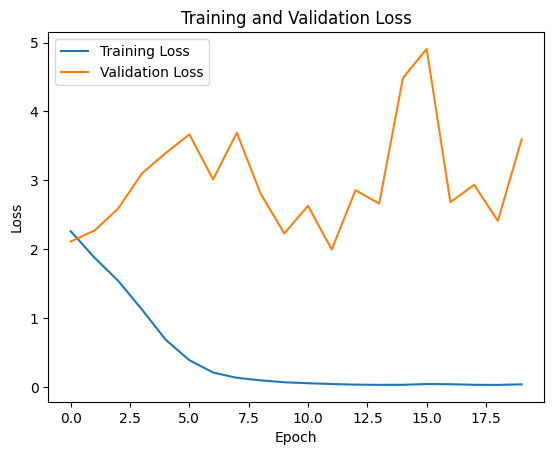

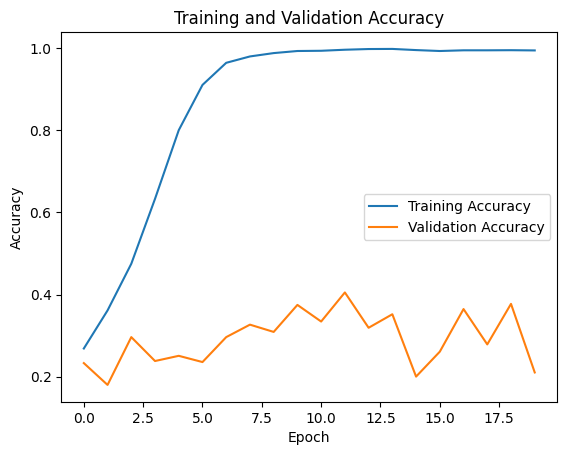

In [ ]:
# Plot training loss
plt.plot(full_history['loss'], label='Training Loss')
plt.plot(full_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(full_history['accuracy'], label='Training Accuracy')
plt.plot(full_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


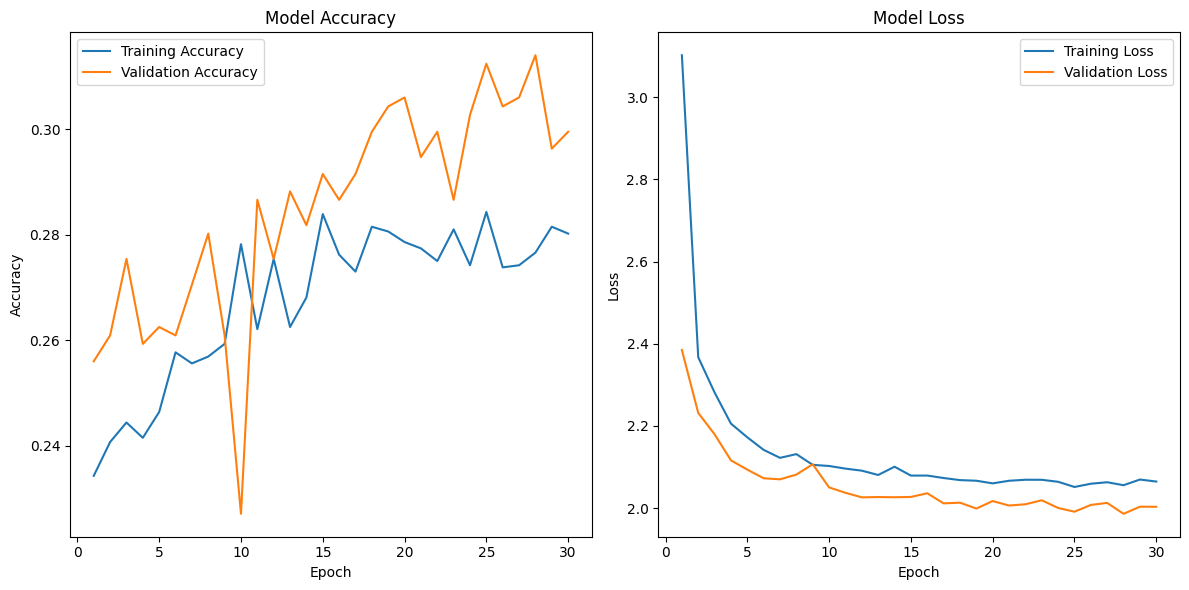

In [ ]:
# import matplotlib.pyplot as plt

# # Define the data
# epochs = list(range(1, 31))  # Assuming 30 epochs
# train_loss = [3.1024, 2.3673, 2.2814, 2.2056, 2.1723, 2.1417, 2.1223, 2.1314, 2.1052, 2.1025, 2.0961, 2.0911, 2.0806, 2.1007, 2.0791, 2.0792, 2.0732, 2.0681, 2.0666, 2.0602, 2.0665, 2.0690, 2.0689, 2.0640, 2.0514, 2.0593, 2.0629, 2.0557, 2.0695, 2.0646]
# val_loss = [2.3848, 2.2317, 2.1796, 2.1162, 2.0936, 2.0726, 2.0700, 2.0816, 2.1067, 2.0504, 2.0372, 2.0261, 2.0269, 2.0264, 2.0271, 2.0361, 2.0115, 2.0132, 1.9988, 2.0171, 2.0062, 2.0093, 2.0190, 2.0003, 1.9912, 2.0077, 2.0126, 1.9861, 2.0034, 2.0032]
# train_accuracy = [0.2343, 0.2407, 0.2444, 0.2415, 0.2464, 0.2577, 0.2556, 0.2569, 0.2593, 0.2782, 0.2621, 0.2754, 0.2625, 0.2681, 0.2839, 0.2762, 0.2730, 0.2815, 0.2806, 0.2786, 0.2774, 0.2750, 0.2810, 0.2742, 0.2843, 0.2738, 0.2742, 0.2766, 0.2815, 0.2802]
# val_accuracy = [0.2560, 0.2609, 0.2754, 0.2593, 0.2625, 0.2609, 0.2705, 0.2802, 0.2609, 0.2271, 0.2866, 0.2754, 0.2882, 0.2818, 0.2915, 0.2866, 0.2915, 0.2995, 0.3043, 0.3060, 0.2947, 0.2995, 0.2866, 0.3027, 0.3124, 0.3043, 0.3060, 0.3140, 0.2963, 0.2995]

# # Plot training & validation accuracy values
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_accuracy, label='Training Accuracy')
# plt.plot(epochs, val_accuracy, label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# # Plot training & validation loss values
# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_loss, label='Training Loss')
# plt.plot(epochs, val_loss, label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()


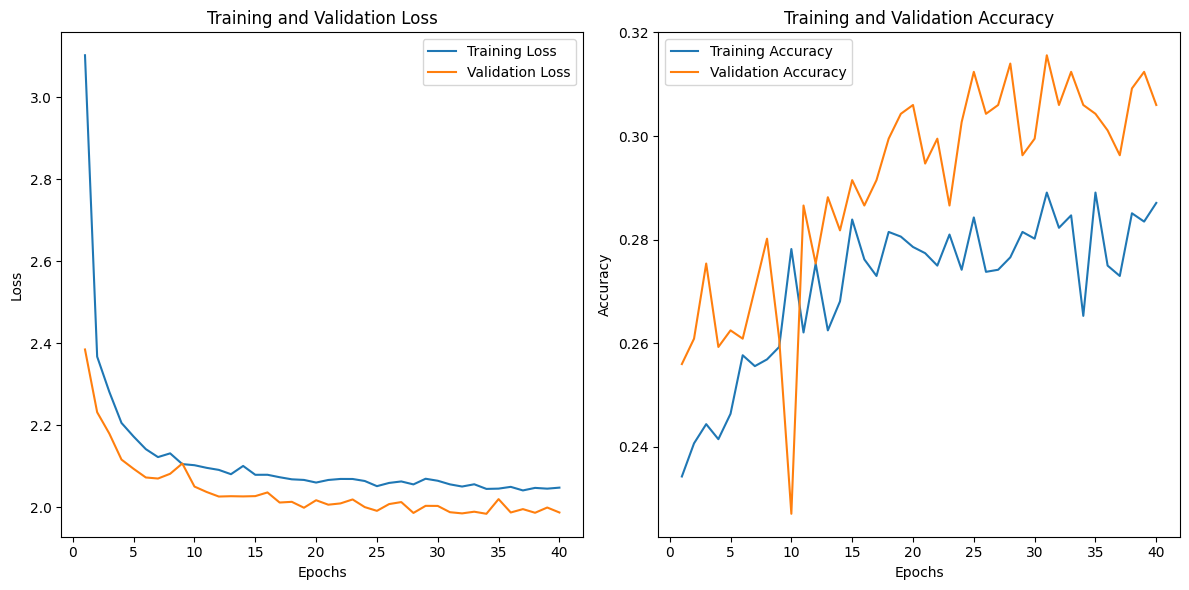

In [ ]:
# # Extend the data
# epochs.extend(list(range(31, 41)))
# train_loss.extend([2.0558, 2.0505, 2.0560, 2.0447, 2.0454, 2.0497, 2.0410, 2.0472, 2.0453, 2.0478])
# val_loss.extend([1.9879, 1.9850, 1.9891, 1.9840, 2.0198, 1.9872, 1.9954, 1.9865, 1.9993, 1.9872])
# train_accuracy.extend([0.2891, 0.2823, 0.2847, 0.2653, 0.2891, 0.2750, 0.2730, 0.2851, 0.2835, 0.2871])
# val_accuracy.extend([0.3156, 0.3060, 0.3124, 0.3060, 0.3043, 0.3011, 0.2963, 0.3092, 0.3124, 0.3060])

# # Plot the data
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))

# # Loss plot
# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_loss, label='Training Loss')
# plt.plot(epochs, val_loss, label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# # Accuracy plot
# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_accuracy, label='Training Accuracy')
# plt.plot(epochs, val_accuracy, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.show()


In [ ]:
#This was without l2 reg

'''
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 1406, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional layers to fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Introducing dropout for regularization
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Introducing dropout for regularization

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary for an overview of the architecture
model.summary()'''

In [ ]:
'''
import keras
# Save the entire model to a file
model.save('/content/drive/MyDrive/colab_data/simple_cnn_3kmel.keras')

# Load the model back
loaded_model = keras.models.load_model('/content/drive/MyDrive/colab_data/simple_cnn_3kmel.keras')'''

In [ ]:
'''
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
'''